# Global School Electricity Access - Machine Learning Analysis
## Comprehensive ML Pipeline with MLflow Tracking

This notebook provides exploratory data analysis and a complete machine learning pipeline for school electricity access data, including:
- Data loading and quality checks
- Exploratory data analysis
- Preprocessing and feature scaling
- Dimensionality reduction (PCA, t-SNE, NMF)
- Clustering (K-Means, Agglomerative, DBSCAN)
- Supervised modeling (classical ML + neural network)
- MLflow experiment tracking and model comparison


## 1. Setup and Imports


In [21]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

NOTEBOOK_DIR = Path.cwd()
IMAGES_DIR = NOTEBOOK_DIR / "images"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    if fig is None:
        fig = plt.gcf()
    out = IMAGES_DIR / f"{name}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print(f"Saved: {out}")
    return out

from src.data_preprocessing import get_preprocessor
from src.dimensionality_reduction import get_reducer
from src.clustering import get_clusterer
from src.classical_models import get_classical_models
from src.evaluation import get_mlflow_tracker

try:
    from src.neural_network_pytorch import get_neural_network_trainer
    TORCH_AVAILABLE = True
except ModuleNotFoundError:
    get_neural_network_trainer = None
    TORCH_AVAILABLE = False

RAW_PATH = PROJECT_ROOT / "data" / "raw" / "electricity_access_data.csv"
if not RAW_PATH.exists():
    from main import create_sample_data
    create_sample_data()

tracking_uri = (PROJECT_ROOT / "mlruns").resolve().as_uri()
mlflow.set_tracking_uri(tracking_uri)
experiment_name = "School_Electricity_Access_ML"
mlflow.set_experiment(experiment_name)

tracker = get_mlflow_tracker(experiment_name)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {RAW_PATH}")
print(f"Images dir: {IMAGES_DIR}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment name: {experiment_name}")
print(f"PyTorch available: {TORCH_AVAILABLE}")


Traceback (most recent call last):
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1655, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\utils\yaml_utils.py", line 104, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\oussa\Downloads\

MLflow experiment set to: School_Electricity_Access_ML
Project root: C:\Users\oussa\Downloads\machine-learning-project
Data path: C:\Users\oussa\Downloads\machine-learning-project\data\raw\electricity_access_data.csv
Images dir: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images
MLflow tracking URI: file:///C:/Users/oussa/Downloads/machine-learning-project/mlruns
Experiment name: School_Electricity_Access_ML
PyTorch available: False


## 2. Exploratory Data Analysis (EDA)


In [22]:
df = pd.read_csv(RAW_PATH)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

display(df.head())
display(df.describe(include="all"))
print("Missing values by column:")
print(df.isna().sum())


Dataset shape: (500, 7)
Columns: ['school_id', 'year', 'access_rate', 'infrastructure_score', 'region', 'development_level', 'investment']


,school_id,year,access_rate,infrastructure_score,region,development_level,investment
0,0,2005,73.164776,31,Asia,Low,97722
1,1,2018,12.768973,45,Asia,High,48684
2,2,2013,25.001645,15,Asia,High,31111
3,3,2009,58.054401,67,Africa,Medium,64936
4,4,2006,86.711661,36,Europe,Low,23614


,school_id,year,access_rate,infrastructure_score,region,development_level,investment
count,500.000000,500.000000,500.000000,500.000000,500,500,500.000000
unique,NaN,NaN,NaN,NaN,4,3,NaN
top,NaN,NaN,NaN,NaN,Asia,Low,NaN
freq,NaN,NaN,NaN,NaN,131,178,NaN
mean,249.500000,2009.084000,50.911833,49.874000,NaN,NaN,48982.808000
std,144.481833,6.683283,27.859903,29.284899,NaN,NaN,28865.184134
min,0.000000,1999.000000,0.259502,0.000000,NaN,NaN,1162.000000
25%,124.750000,2003.000000,27.196580,24.000000,NaN,NaN,23392.750000
50%,249.500000,2009.000000,52.800893,48.500000,NaN,NaN,48491.500000
75%,374.250000,2015.000000,74.422116,75.250000,NaN,NaN,74583.000000


Missing values by column:
school_id               0
year                    0
access_rate             0
infrastructure_score    0
region                  0
development_level       0
investment              0
dtype: int64


Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\eda_numeric_distributions.png


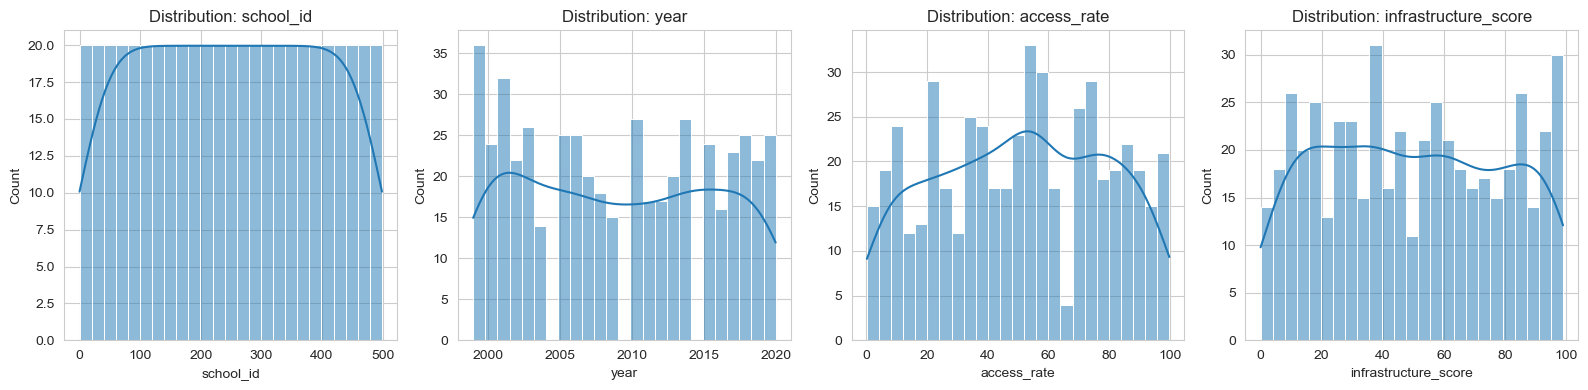

Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\eda_correlation_heatmap.png


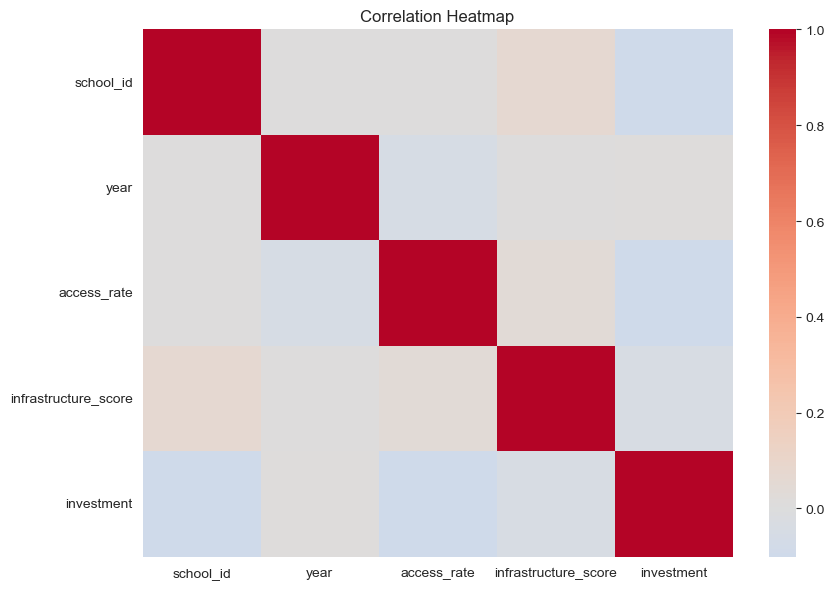

Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\eda_category_counts_region.png


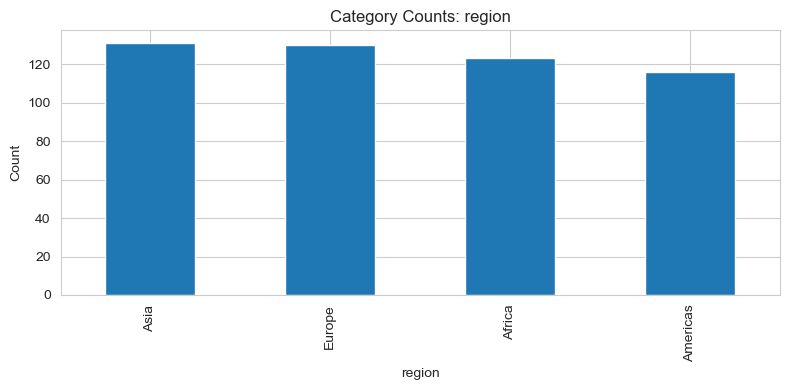

Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\eda_category_counts_development_level.png


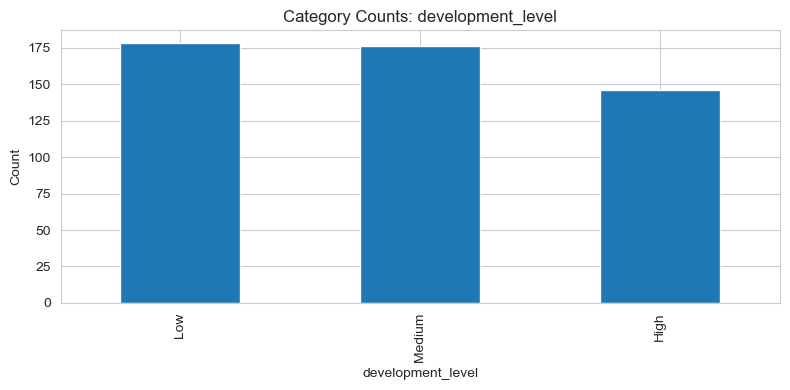

In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

fig, axes = plt.subplots(1, min(4, len(numeric_cols)), figsize=(16, 4))
if len(numeric_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, numeric_cols[:4]):
    sns.histplot(df[col], bins=25, kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
plt.tight_layout()
save_fig("eda_numeric_distributions", fig)
plt.show()

if len(numeric_cols) >= 2:
    fig, ax = plt.subplots(figsize=(9, 6))
    corr = df[numeric_cols].corr(numeric_only=True)
    sns.heatmap(corr, cmap="coolwarm", center=0, ax=ax)
    ax.set_title("Correlation Heatmap")
    plt.tight_layout()
    save_fig("eda_correlation_heatmap", fig)
    plt.show()

if cat_cols:
    for col in cat_cols[:2]:
        fig, ax = plt.subplots(figsize=(8, 4))
        df[col].value_counts().plot(kind="bar", ax=ax)
        ax.set_title(f"Category Counts: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        safe_col = col.lower().replace(" ", "_")
        save_fig(f"eda_category_counts_{safe_col}", fig)
        plt.show()


## 3. Data Preprocessing


In [24]:
with mlflow.start_run(run_name="Preprocessing"):
    preprocessor = get_preprocessor()
    X_train, X_test, y_train, y_test, X_train_df = preprocessor.preprocess_pipeline(
        str(RAW_PATH), test_size=0.2
    )

    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("train_samples", int(X_train.shape[0]))
    mlflow.log_metric("test_samples", int(X_test.shape[0]))
    mlflow.log_metric("n_features", int(X_train.shape[1]))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:", np.bincount(y_train))
print("y_test distribution:", np.bincount(y_test))


STARTING PREPROCESSING PIPELINE
Loading data from C:\Users\oussa\Downloads\machine-learning-project\data\raw\electricity_access_data.csv...
Dataset shape: (500, 7)
Columns: ['school_id', 'year', 'access_rate', 'infrastructure_score', 'region', 'development_level', 'investment']

Handling missing values...
Missing values after handling: 0

Creating target variable...
Target variable distribution:
target
0    250
1    250
Name: count, dtype: int64

Encoding categorical variables...

Train set: (400, 7)
Test set: (100, 7)

Normalizing features...
Scaler fitted on training data

PREPROCESSING COMPLETE
X_train shape: (400, 7)
X_test shape: (100, 7)
y_train distribution: [200 200]
y_test distribution: [50 50]


## 4. Dimensionality Reduction



Full PCA Analysis:
Components needed for 95% variance: 7
Original shape: (400, 7)
Reduced shape: (400, 7)

Applying PCA with 2 components...
Explained variance ratio: [0.17961343 0.15872721]
Total variance explained: 0.3383

Applying PCA with 2 components...
Explained variance ratio: [0.18553774 0.18113858]
Total variance explained: 0.3667

Applying t-SNE with 2 components...
Perplexity: 30, Iterations: 1000
t-SNE output shape: (400, 2)

Applying NMF with 2 components...
NMF reconstruction error: 43.6767
NMF output shape: (400, 2)
Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\dimred_pca_cumulative_variance.png


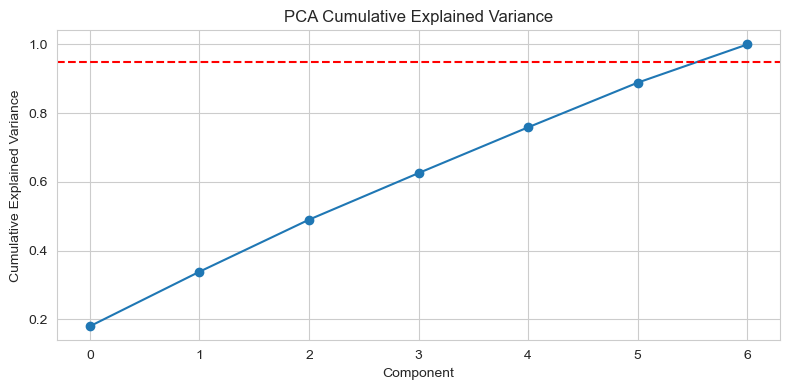

In [25]:
reducer = get_reducer()

with mlflow.start_run(run_name="Dimensionality_Reduction"):
    pca_full, X_train_pca_full = reducer.apply_pca_full(X_train)
    X_train_pca_2d = reducer.apply_pca(X_train, n_components=2)
    X_test_pca_2d = reducer.apply_pca(X_test, n_components=2)
    X_train_tsne = reducer.apply_tsne(X_train, n_components=2, perplexity=30)
    X_train_nmf = reducer.apply_nmf(X_train, n_components=2)

    explained = float(np.sum(pca_full.explained_variance_ratio_))
    cumsum = np.cumsum(pca_full.explained_variance_ratio_)
    n95 = int(np.argmax(cumsum >= 0.95) + 1)

    mlflow.log_metric("pca_total_variance", explained)
    mlflow.log_metric("pca_components_for_95pct", n95)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
ax.axhline(0.95, linestyle="--", color="red")
ax.set_title("PCA Cumulative Explained Variance")
ax.set_xlabel("Component")
ax.set_ylabel("Cumulative Explained Variance")
plt.tight_layout()
save_fig("dimred_pca_cumulative_variance", fig)
plt.show()


Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\dimred_2d_projections.png


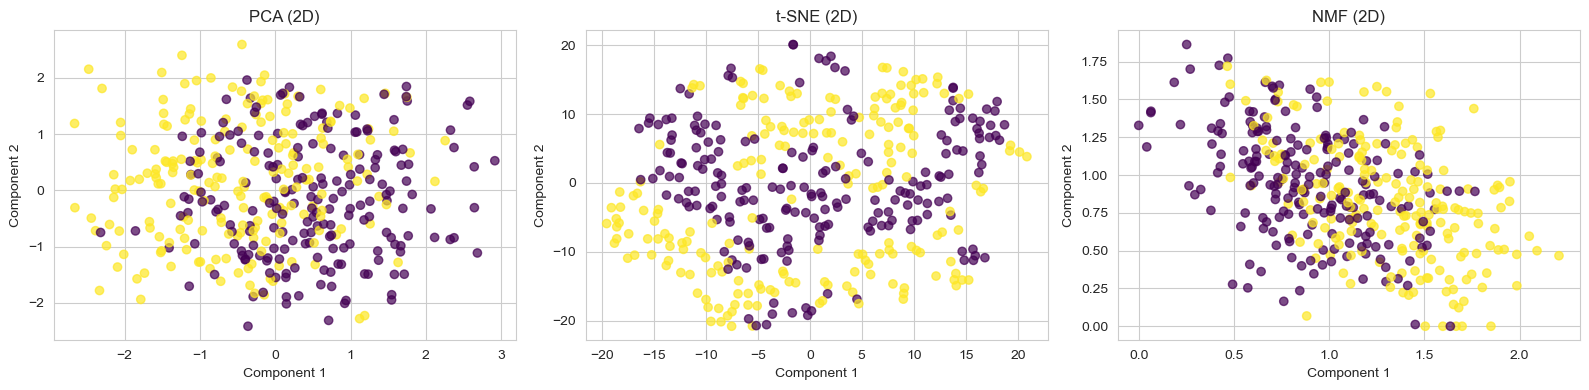

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, cmap="viridis", alpha=0.7)
axes[0].set_title("PCA (2D)")

axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="viridis", alpha=0.7)
axes[1].set_title("t-SNE (2D)")

axes[2].scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=y_train, cmap="viridis", alpha=0.7)
axes[2].set_title("NMF (2D)")

for ax in axes:
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

plt.tight_layout()
save_fig("dimred_2d_projections", fig)
plt.show()


## 5. Clustering Analysis



Performing Elbow Method analysis...
Inertias: [2464.6042912231856, 2237.5968351744336, 2079.909676887051, 1957.5236345131964, 1833.7662920805933, 1748.4716949436738, 1650.2183853736265, 1587.8972747641005, 1546.3650351763652]
Silhouette Scores: [np.float64(0.11430366425224317), np.float64(0.10933027341567314), np.float64(0.10997205447047065), np.float64(0.10935006143178758), np.float64(0.12053872518727513), np.float64(0.11974346977009587), np.float64(0.12653941878515906), np.float64(0.12325167003428614), np.float64(0.11950069161966635)]

Applying K-Means with 3 clusters...
Inertia: 2237.5968
Silhouette Score: 0.1093
Davies-Bouldin Index: 2.3487

Applying Agglomerative Clustering (ward linkage)...
Number of clusters: 3
Silhouette Score: 0.0738
Davies-Bouldin Index: 2.6753

Applying DBSCAN (eps=0.5, min_samples=5)...
Number of clusters: 0
Number of noise points: 400
Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\clustering_elbow_silhouette.png


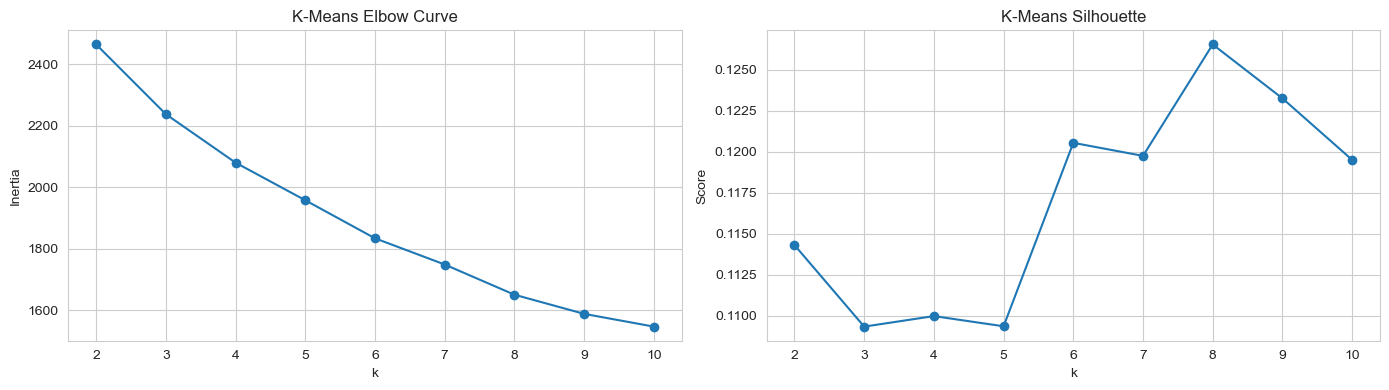

In [27]:
import importlib
import src.clustering as clustering_module

importlib.reload(clustering_module)
clusterer = clustering_module.get_clusterer()

with mlflow.start_run(run_name="Clustering"):
    inertias, silhouettes = clusterer.elbow_method(X_train, k_range=range(2, 11))
    kmeans_labels = clusterer.apply_kmeans(X_train, n_clusters=3)
    agg_labels = clusterer.apply_agglomerative(X_train, n_clusters=3, linkage="ward")
    dbscan_labels = clusterer.apply_dbscan(X_train, eps=0.5, min_samples=5)

    mlflow.log_metric("kmeans_silhouette_k3", float(silhouettes[1]))
    mlflow.log_metric("kmeans_inertia_k3", float(inertias[1]))

    db_n_clusters = int(len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
    db_noise = int(np.sum(dbscan_labels == -1))
    mlflow.log_metric("dbscan_clusters", db_n_clusters)
    mlflow.log_metric("dbscan_noise", db_noise)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(range(2, 11), inertias, marker="o")
axes[0].set_title("K-Means Elbow Curve")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")

axes[1].plot(range(2, 11), silhouettes, marker="o")
axes[1].set_title("K-Means Silhouette")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Score")

plt.tight_layout()
save_fig("clustering_elbow_silhouette", fig)
plt.show()


Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\clustering_assignments_pca.png


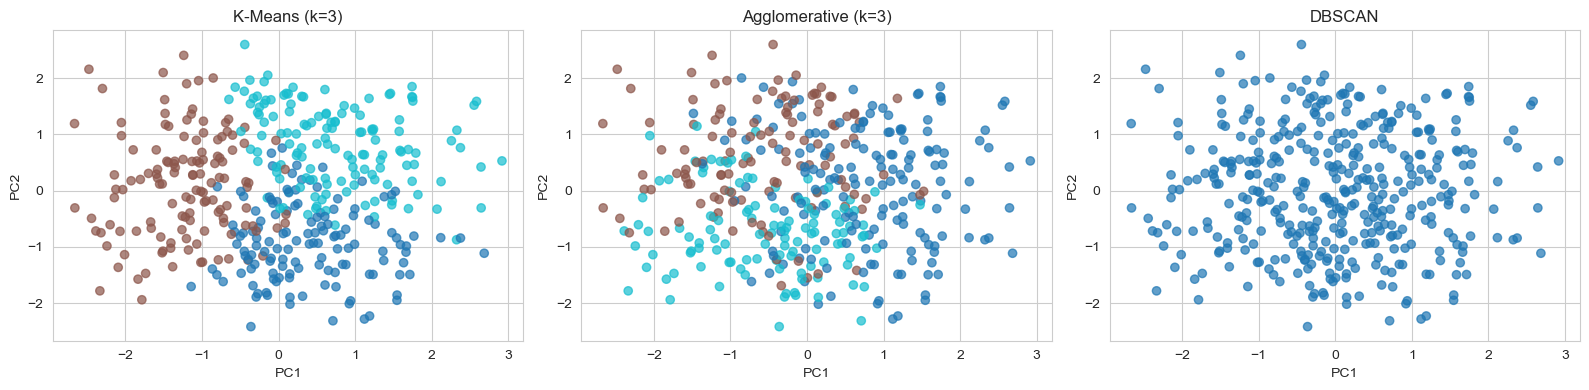

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=kmeans_labels, cmap="tab10", alpha=0.7)
axes[0].set_title("K-Means (k=3)")

axes[1].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=agg_labels, cmap="tab10", alpha=0.7)
axes[1].set_title("Agglomerative (k=3)")

axes[2].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=dbscan_labels, cmap="tab10", alpha=0.7)
axes[2].set_title("DBSCAN")

for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
save_fig("clustering_assignments_pca", fig)
plt.show()


## 6. Supervised Models (Classical + Neural Network)


In [29]:
classical = get_classical_models()

with mlflow.start_run(run_name="Classical_Models"):
    classical.logistic_regression(X_train, y_train, X_test, y_test)
    classical.knn(X_train, y_train, X_test, y_test, n_neighbors=5)
    classical.decision_tree(X_train, y_train, X_test, y_test, max_depth=10)
    classical.svm(X_train, y_train, X_test, y_test, kernel="rbf")
    classical.random_forest(X_train, y_train, X_test, y_test, n_estimators=100)
    classical.adaboost(X_train, y_train, X_test, y_test, n_estimators=50)
    classical.gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=100)

    for model_name, metrics in classical.results.items():
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"{model_name}_{metric_name}".replace(" ", "_"), float(metric_value))

results_df = classical.get_results_df().sort_values("f1", ascending=False)
display(results_df)



LOGISTIC REGRESSION
Training Accuracy: 1.0000
Test Accuracy:  0.9600
Precision:      0.9423
Recall:         0.9800
F1-Score:       0.9608

K-NEAREST NEIGHBORS (k=5)
Training Accuracy: 0.9350
Test Accuracy:  0.9100
Precision:      0.8727
Recall:         0.9600
F1-Score:       0.9143

DECISION TREE (max_depth=10)
Training Accuracy: 1.0000
Test Accuracy:  1.0000
Precision:      1.0000
Recall:         1.0000
F1-Score:       1.0000

SUPPORT VECTOR MACHINE (kernel=rbf)
Training Accuracy: 0.9850
Test Accuracy:  0.9500
Precision:      0.9245
Recall:         0.9800
F1-Score:       0.9515

RANDOM FOREST (n_estimators=100, max_depth=10)
Training Accuracy: 1.0000
Test Accuracy:  1.0000
Precision:      1.0000
Recall:         1.0000
F1-Score:       1.0000

ADABOOST (n_estimators=50)
Training Accuracy: 1.0000
Test Accuracy:  1.0000
Precision:      1.0000
Recall:         1.0000
F1-Score:       1.0000

GRADIENT BOOSTING (n_estimators=100, lr=0.1)
Training Accuracy: 1.0000
Test Accuracy:  1.0000
Precis

,accuracy,precision,recall,f1
Decision Tree,1.00,1.000000,1.00,1.000000
AdaBoost,1.00,1.000000,1.00,1.000000
Random Forest,1.00,1.000000,1.00,1.000000
Gradient Boosting,1.00,1.000000,1.00,1.000000
Logistic Regression,0.96,0.942308,0.98,0.960784
SVM,0.95,0.924528,0.98,0.951456
KNN,0.91,0.872727,0.96,0.914286


Saved: c:\Users\oussa\Downloads\machine-learning-project\notebooks\images\classification_model_comparison.png


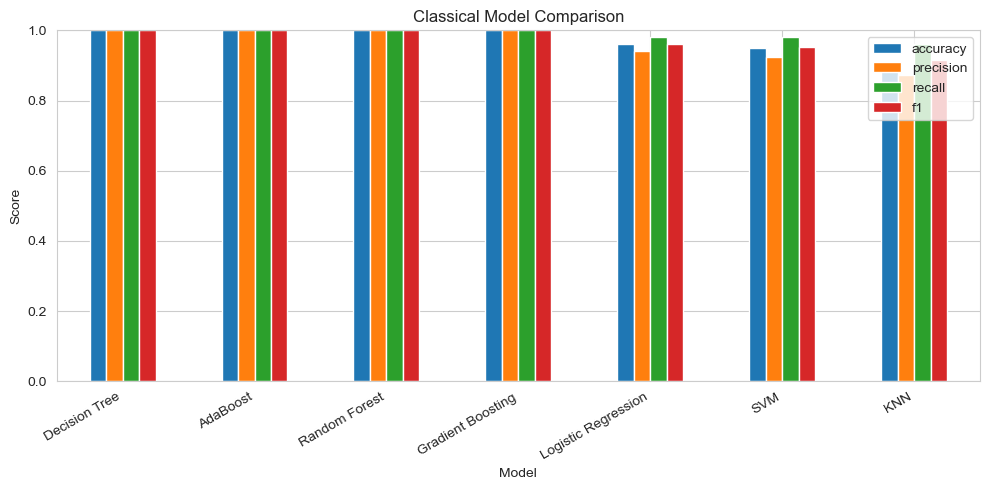

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
results_df[["accuracy", "precision", "recall", "f1"]].plot(kind="bar", ax=ax)
ax.set_title("Classical Model Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xlabel("Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
save_fig("classification_model_comparison", fig)
plt.show()


In [31]:
if TORCH_AVAILABLE:
    input_size = X_train.shape[1]
    output_size = len(np.unique(y_train))
    nn_trainer = get_neural_network_trainer(input_size, output_size, hidden_sizes=[128, 64, 32])

    with mlflow.start_run(run_name="Neural_Network"):
        nn_trainer.fit(X_train, y_train, X_test, y_test, epochs=50, batch_size=32, verbose=10)
        nn_metrics = nn_trainer.evaluate(X_test, y_test)

        for metric_name, metric_value in nn_metrics.items():
            mlflow.log_metric(f"nn_{metric_name}", float(metric_value))

    history_fig = nn_trainer.plot_training_history()
    save_fig("neural_network_training_history", history_fig)
    plt.show()

    print("Neural network metrics:", nn_metrics)
else:
    nn_metrics = None
    print("Skipping neural network section because PyTorch is not installed.")
    print("Install with: pip install torch")


Skipping neural network section because PyTorch is not installed.
Install with: pip install torch


## 7. MLflow Tracking Summary and Best Model


In [32]:
all_results = dict(classical.results)
if nn_metrics is not None:
    all_results["Neural Network"] = nn_metrics

summary_df = pd.DataFrame(all_results).T.sort_values("f1", ascending=False)
display(summary_df)

best_model_name = summary_df.index[0]
best_row = summary_df.iloc[0]

print("Best model:", best_model_name)
print("Best metrics:")
print(best_row.to_dict())

with mlflow.start_run(run_name="Final_Summary"):
    mlflow.log_param("best_model", best_model_name)
    for metric_name, metric_value in best_row.to_dict().items():
        mlflow.log_metric(f"best_{metric_name}", float(metric_value))


,accuracy,precision,recall,f1
Decision Tree,1.00,1.000000,1.00,1.000000
AdaBoost,1.00,1.000000,1.00,1.000000
Random Forest,1.00,1.000000,1.00,1.000000
Gradient Boosting,1.00,1.000000,1.00,1.000000
Logistic Regression,0.96,0.942308,0.98,0.960784
SVM,0.95,0.924528,0.98,0.951456
KNN,0.91,0.872727,0.96,0.914286


Best model: Decision Tree
Best metrics:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


In [33]:
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id]).sort_values("start_time", ascending=False)

print("Experiment ID:", experiment.experiment_id)
print("Total runs:", len(runs))
display(runs[["run_id", "status", "start_time", "tags.mlflow.runName"]].head(15))

print("To open UI:")
print("mlflow ui --backend-store-uri", tracking_uri)
print("Then open http://127.0.0.1:5000")


Traceback (most recent call last):
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1655, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\oussa\anaconda3\Lib\site-packages\mlflow\utils\yaml_utils.py", line 104, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\oussa\Downloads\

Experiment ID: 905967612892822029
Total runs: 11


,run_id,status,start_time,tags.mlflow.runName
0,f0605619991c4ddaaba00f64dc0d65ee,FINISHED,2026-02-13 11:08:01.942000+00:00,Final_Summary
1,620ed22a64d04fbb9693360dd8f9c02c,FINISHED,2026-02-13 11:07:58.945000+00:00,Classical_Models
2,64f76dc9530f41cdb62bf1291b6a06cc,FINISHED,2026-02-13 11:07:53.473000+00:00,Clustering
3,027aad30dcce4c5eb0f4b31fef1e969d,FINISHED,2026-02-13 11:07:46.732000+00:00,Dimensionality_Reduction
4,568a377fbceb4434a9a914d0d818ba4a,FINISHED,2026-02-13 11:07:46.506000+00:00,Preprocessing
5,f5a5a42e209345fb9d2870c8679e6010,FINISHED,2026-02-13 11:03:37.128000+00:00,Final_Summary
6,fa81da20196a41349b75c19ad7fd8b49,FINISHED,2026-02-13 11:03:17.900000+00:00,Classical_Models
7,d592d30602624a19b8c1d177f6bcf2ac,FINISHED,2026-02-13 11:03:04.658000+00:00,Clustering
8,9368659e108d47a59d4e5968af068e0b,FAILED,2026-02-13 11:01:49.994000+00:00,Clustering
9,860a3b8e79db48e4a2448ae49af77a4f,FINISHED,2026-02-13 11:01:44.703000+00:00,Dimensionality_Reduction


To open UI:
mlflow ui --backend-store-uri file:///C:/Users/oussa/Downloads/machine-learning-project/mlruns
Then open http://127.0.0.1:5000
